In [1]:
# Import all the tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 0. Input Data

### Function for loading and preparing data

In [2]:
def data_prepare_x_train():
    df_train = pd.read_csv("data/ventilator-pressure-prediction/train.csv")
    df_train = df_train.drop("id", axis=1)
    #df_train = df_train.drop("breath_id", axis=1)
    #df_train = df_train.drop("R", axis=1)
    # df_train = df_train.drop("C", axis=1)
    #df_train = df_train.drop("u_out", axis=1)
    x_train = df_train.drop("pressure", axis=1)
    return x_train

In [3]:
def data_prepare_y_train():
    df_train = pd.read_csv("data/ventilator-pressure-prediction/train.csv")
    y_train = df_train["pressure"]
    return y_train

In [4]:
def data_prepare_x_test():
    df_test = pd.read_csv("data/ventilator-pressure-prediction/test.csv")
    x_test = df_test
    return x_test

In [5]:
x_train = data_prepare_x_train()
x_train[:2]

breath_id   R   C  time_step       u_in  u_out
0          1  20  50   0.000000   0.083334      0
1          1  20  50   0.033652  18.383041      0

In [6]:
y_train = data_prepare_y_train()
y_train[:2]

0    5.837492
1    5.907794
Name: pressure, dtype: float64

In [7]:
x_test = data_prepare_x_test()
x_test[:2]

id  breath_id  R   C  time_step      u_in  u_out
0   1          0  5  20   0.000000  0.000000      0
1   2          0  5  20   0.031904  7.515046      0

### Y adjustment

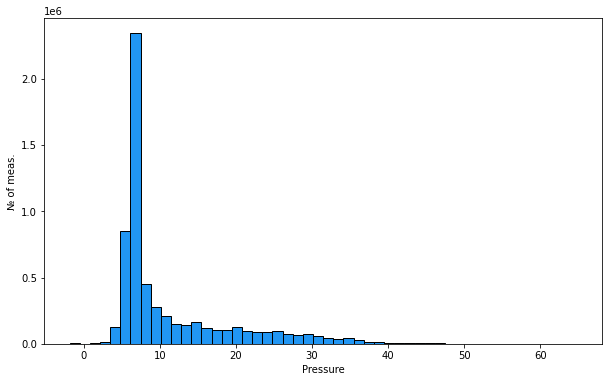

In [8]:
plt.figure(figsize=(10,6))
plt.hist(y_train, bins=50, ec='black', color='#2196f3')
plt.xlabel("Pressure")
plt.ylabel("№ of meas.")
plt.show()

In [9]:
y_log = np.log(y_train)
y_log[:2]

C:\Users\misha\Desktop\sample_project_1\env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0    1.764301
1    1.776272
Name: pressure, dtype: float64

In [10]:
y_log.skew()

0.8622268058052204

In [11]:
y_log.isna().sum()

3713

In [12]:
y_log.dropna(inplace=True)

In [13]:
# sns.distplot(y_log)
# plt.title(f'Log pressure with skew {y_log.skew()}')
# plt.show()

### Check outliers

<AxesSubplot:>

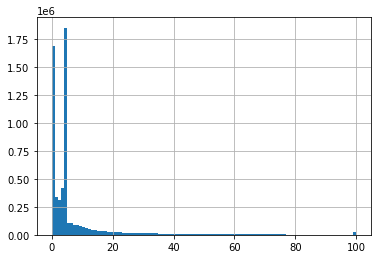

In [14]:
x_train['u_in'].hist(bins=100)

In [15]:
x_train['u_in'].describe()

count    6.036000e+06
mean     7.321615e+00
std      1.343470e+01
min      0.000000e+00
25%      3.936623e-01
50%      4.386146e+00
75%      4.983895e+00
max      1.000000e+02
Name: u_in, dtype: float64

### Boxplots

In [16]:
x_train[:1]

breath_id   R   C  time_step      u_in  u_out
0          1  20  50        0.0  0.083334      0

<AxesSubplot:>

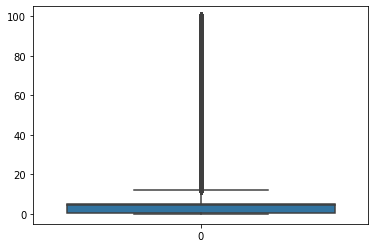

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=x_train['u_in'])

<AxesSubplot:>

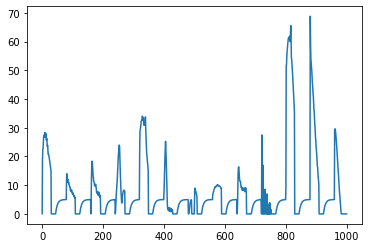

In [18]:
x_train.u_in[:1000].plot()

### Remove outliers

### u_in

In [19]:
for x in ['u_in']:
    q75,q25 = np.percentile(x_train.loc[:,x],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    x_train.loc[x_train[x] < min,x] = np.nan
    x_train.loc[x_train[x] > max,x] = np.nan

In [20]:
x_train.isnull().sum()

breath_id         0
R                 0
C                 0
time_step         0
u_in         836873
u_out             0
dtype: int64

<AxesSubplot:>

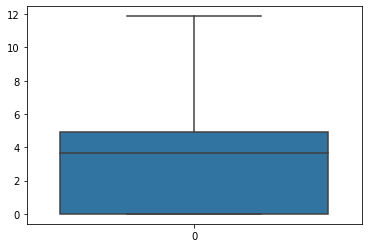

In [21]:
sns.boxplot(data=x_train['u_in'])

In [22]:
x_train["u_in"].fillna(x_train["u_in"].mean(), inplace = True)

In [23]:
x_train.isnull().sum()

breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
dtype: int64

<AxesSubplot:>

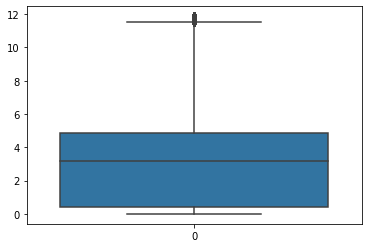

In [24]:
sns.boxplot(data=x_train['u_in'])

### Uninformed features
Let's make a list of features that contain more than 95% containing the same value.

In [316]:
num_rows = len(x_train.index)
low_information_cols = [] #
for col in x_train.columns:
    cnts = x_train[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

### drop_duplicates

In [317]:
x_train[:1]

R   C  time_step      u_in  u_out
0  20  50        0.0  0.083334      0

In [318]:
# key = ['time_step', 'u_in']
# x_train.fillna(-999).groupby(key)['id'].count().sort_values(ascending=False).head(20)

In [319]:
#x_train_dropped = x_train.drop('u_in', axis=1).drop_duplicates()
#x_train_dropped = x_train.drop('time_step', axis=1).drop_duplicates()

#print(x_train.shape)
#print(x_train_dropped.shape)

In [320]:
#x_train_dropped[:2]

### Function adding distributions for `x_train`

In [8]:
def add_data_distributions_for_x_train(x_train):
    np.random.seed(42)

    fix, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,5))
    ax1.set_title("normal distribution")
    ax2.set_title("uniform distribution")
    ax3.set_title("laplace distribution")
    for i in range(3):
        x_train.loc[:, f'norm_{i}'] = np.random.normal(loc=np.random.randint(low=0, high=10), 
                                                 scale=np.random.randint(low=1, high=10), 
                                                 size=(x_train.shape[0], 1))
    
        x_train.loc[:, f'unif_{i}'] = np.random.uniform(low=np.random.randint(low=1, high=4), 
                                                  high=np.random.randint(low=5, high=10), 
                                                  size=(x_train.shape[0], 1))
        x_train.loc[:, f'lapl_{i}'] = np.random.laplace(loc=np.random.randint(low=0, high=10), 
                                                  scale=np.random.randint(low=1, high=10), 
                                                  size=(x_train.shape[0], 1))
        # visualize
        sns.kdeplot(x_train[f'norm_{i}'], ax=ax1)
        sns.kdeplot(x_train[f'unif_{i}'], ax=ax2)
        sns.kdeplot(x_train[f'lapl_{i}'], ax=ax3)

    # new x_train
    x_train.head()
    return x_train

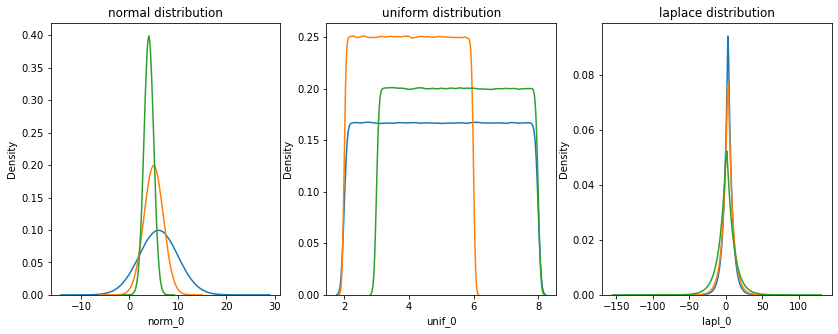

In [19]:
x_train = add_data_distributions_for_x_train(x_train)

### Function adding distributions for `x_test`

In [6]:
def add_data_distributions_for_x_test(x_test):
    np.random.seed(42)

    fix, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,5))
    ax1.set_title("normal distribution")
    ax2.set_title("uniform distribution")
    ax3.set_title("laplace distribution")
    for i in range(3):
        x_test.loc[:, f'norm_{i}'] = np.random.normal(loc=np.random.randint(low=0, high=10), 
                                                 scale=np.random.randint(low=1, high=10), 
                                                 size=(x_test.shape[0], 1))
    
        x_test.loc[:, f'unif_{i}'] = np.random.uniform(low=np.random.randint(low=1, high=4), 
                                                  high=np.random.randint(low=5, high=10), 
                                                  size=(x_test.shape[0], 1))
        x_test.loc[:, f'lapl_{i}'] = np.random.laplace(loc=np.random.randint(low=0, high=10), 
                                                  scale=np.random.randint(low=1, high=10), 
                                                  size=(x_test.shape[0], 1))

        sns.kdeplot(x_test[f'norm_{i}'], ax=ax1)
        sns.kdeplot(x_test[f'unif_{i}'], ax=ax2)
        sns.kdeplot(x_test[f'lapl_{i}'], ax=ax3)


    x_test.head()
    return x_test

### Standartization

In [44]:
x_train[:2]

breath_id   R   C  time_step       u_in  u_out
0          1  20  50   0.000000   0.083334      0
1          1  20  50   0.033652  18.383041      0

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(x_train)

newX = pd.DataFrame(X_train)
#newX.rename(columns={ newX.columns[0]: "id" }, inplace = True)
newX.rename(columns={ newX.columns[0]: "breath_id" }, inplace = True)
newX.rename(columns={ newX.columns[1]: "R" }, inplace = True)
newX.rename(columns={ newX.columns[2]: "C" }, inplace = True)
newX.rename(columns={ newX.columns[3]: "time_step" }, inplace = True)
newX.rename(columns={ newX.columns[4]: "u_in" }, inplace = True)
newX.rename(columns={ newX.columns[5]: "u_out" }, inplace = True)
newX[:2]

breath_id         R         C  time_step      u_in     u_out
0  -1.729391 -0.359072  1.394522  -1.706609 -0.538775 -1.278552
1  -1.729391 -0.359072  1.394522  -1.662676  0.823348 -1.278552

In [53]:
# fig, (ax1) = plt.subplots(ncols = 1, figsize = (10, 8))
# ax1.set_title('Оригинальные распределения')

# # kdeplot()-distribution
# sns.kdeplot(newX['u_in'], ax = ax1)

# 1.Data analysis

### Function for visualizing  features

In [50]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [51]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(task_type="GPU",
                         loss_function= 'MAE',
                         devices='0:1')
model.fit(newX, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4.9692021	total: 48.7ms	remaining: 48.7s
1:	learn: 4.8620212	total: 95.7ms	remaining: 47.7s
2:	learn: 4.7587369	total: 142ms	remaining: 47.3s
3:	learn: 4.6607376	total: 189ms	remaining: 47.2s
4:	learn: 4.5680089	total: 236ms	remaining: 46.9s
5:	learn: 4.4804765	total: 283ms	remaining: 46.9s
6:	learn: 4.3958787	total: 329ms	remaining: 46.7s
7:	learn: 4.3192651	total: 376ms	remaining: 46.6s
8:	learn: 4.2468101	total: 423ms	remaining: 46.6s
9:	learn: 4.1688883	total: 471ms	remaining: 46.6s
10:	learn: 4.0944864	total: 519ms	remaining: 46.7s
11:	learn: 4.0267727	total: 565ms	remaining: 46.5s
12:	learn: 3.9623204	total: 611ms	remaining: 46.4s
13:	learn: 3.9080765	total: 657ms	remaining: 46.3s
14:	learn: 3.8504095	total: 706ms	remaining: 46.3s
15:	learn: 3.7974394	total: 752ms	remaining: 46.3s
16:	learn: 3.7442561	total: 799ms	remaining: 46.2s
17:	learn: 3.6934085	total: 847ms	remaining: 46.2s
18:	learn: 3.6450195	total: 893ms	remaining: 46.1s
19:	learn: 3.5951392	total: 942ms	remai

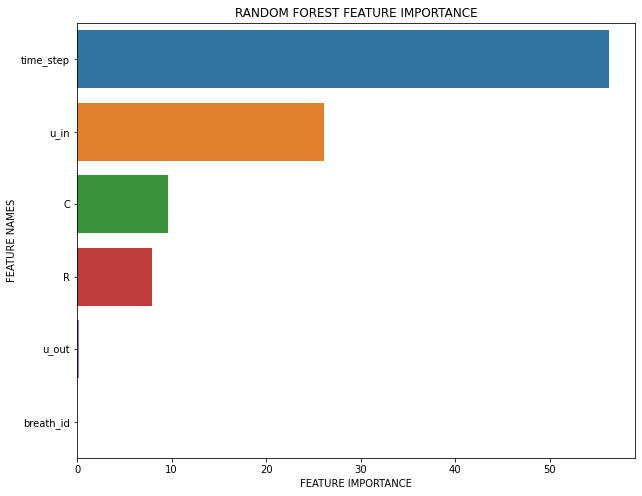

In [52]:
plot_feature_importance(model.feature_importances_, x_train.columns, 'RANDOM FOREST ')

In [54]:
model.score(newX, y_train)

0.7185709497770807

# Multiple regression

### `P-value`

In [47]:
import statsmodels.api as sm 
x_inc_const = sm.add_constant(newX)

model = sm.OLS(y_train,x_inc_const)
results = model.fit()

pd.DataFrame({'coef': results.params, 'p-value':round(results.pvalues, 3)})

coef  p-value
const      11.220408      0.0
breath_id  -0.016189      0.0
R           0.146360      0.0
C          -0.356189      0.0
time_step  -0.230392      0.0
u_in        0.599665      0.0
u_out      -4.540910      0.0

### Multicollinearity

In [48]:
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
variance_inflation_factor(exog=x_inc_const, exog_idx=1)

1.0000716397141092

In [49]:
#Коэффициент увеличения дисперсии Википедия  site:livepcwiki.ru
# < 10
vif = [variance_inflation_factor(exog=x_inc_const.values,
                                exog_idx=i) for i in range(x_inc_const.shape[1])]
pd.DataFrame({'coef_name': x_inc_const.columns,
             'vif': np.around(vif,2)})

coef_name   vif
0      const  1.00
1  breath_id  1.00
2          R  1.03
3          C  1.03
4  time_step  3.38
5       u_in  1.28
6      u_out  3.59

### Pattern in errors

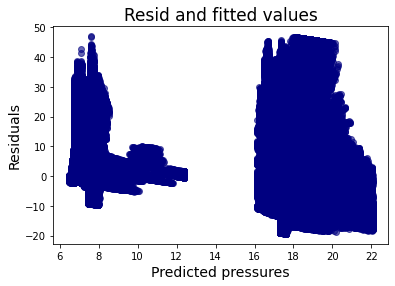

In [74]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(newX, y_train, test_size=0.2)

# Stats model
x_inc1 = sm.add_constant(x_train_2)
model = sm.OLS(y_train_2, x_inc1)
results = model.fit()


# Residuals sum:((y_preds - y_true)^2)/n and y_preds
plt.scatter(x=results.fittedvalues, y=results.resid, c='navy', alpha=0.6)

plt.xlabel('Predicted pressures', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Resid and fitted values', fontsize=17)

plt.show()
# Not fine. Idel is cloud. See the problem in data. Regularity in errors

### Distribution of errors

C:\Users\misha\Desktop\sample_project_1\env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

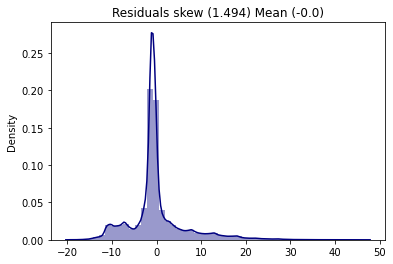

In [76]:
resid_mean = round(results.resid.mean(), 3)
resid_skew = round(results.resid.skew(), 3)

sns.distplot(results.resid, color='navy')
plt.title(f'Residuals skew ({resid_skew}) Mean ({resid_mean})')
plt.show

### Intervals

In [80]:
# 95%

# mse & r^2

reduced_mse = round(results.mse_resid, 3) # round our STD

print('', 2*np.sqrt(reduced_mse))

upper_bound = 20 + 0.05*np.sqrt(reduced_mse)
print('Upper bound', np.e**upper_bound*1000)

lower_bound = 20 - 0.05*np.sqrt(reduced_mse)
print('Lower bound', np.e**lower_bound*1000)

 12.73561934104502
Upper bound 667059952418.2446
Lower bound 352869732298.71497


### Check the distribution of the age column with a histogram

<AxesSubplot:ylabel='Frequency'>

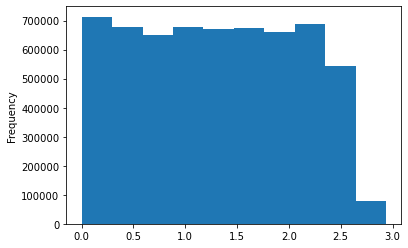

In [100]:
x_train.time_step.plot.hist()

### Accuracy on cross-validation

In [90]:
from catboost import CatBoostRegressor

scores = np.array([])


model_1 = CatBoostRegressor(task_type="GPU",
                            random_seed=42,
                            loss_function= 'MAE',
                            devices='0:1')

scores = cross_val_score(model_1, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')

print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))
#plot_features_scores(data=x_train, target=y_train, column_names=x_train.columns, model_type='rf')

0:	learn: 4.9657894	total: 41.6ms	remaining: 41.5s
1:	learn: 4.8586568	total: 82.1ms	remaining: 41s
2:	learn: 4.7554776	total: 123ms	remaining: 40.8s
3:	learn: 4.6575306	total: 163ms	remaining: 40.7s
4:	learn: 4.5648016	total: 204ms	remaining: 40.6s
5:	learn: 4.4740006	total: 246ms	remaining: 40.7s
6:	learn: 4.3908242	total: 286ms	remaining: 40.6s
7:	learn: 4.3096475	total: 326ms	remaining: 40.4s
8:	learn: 4.2369980	total: 366ms	remaining: 40.3s
9:	learn: 4.1669251	total: 406ms	remaining: 40.2s
10:	learn: 4.0929858	total: 447ms	remaining: 40.2s
11:	learn: 4.0223401	total: 487ms	remaining: 40.1s
12:	learn: 3.9581271	total: 527ms	remaining: 40s
13:	learn: 3.9031465	total: 566ms	remaining: 39.8s
14:	learn: 3.8472473	total: 606ms	remaining: 39.8s
15:	learn: 3.7944968	total: 646ms	remaining: 39.7s
16:	learn: 3.7434713	total: 686ms	remaining: 39.7s
17:	learn: 3.6931946	total: 727ms	remaining: 39.6s
18:	learn: 3.6427696	total: 767ms	remaining: 39.6s
19:	learn: 3.5931465	total: 807ms	remaining

# Function for MAE

In [41]:
# Create evaluation function (RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and true labels
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))


# Create function to evaluate model on a few different levels
def show_scores(model, x_train):
    y_preds = model.predict(x_train)
    scores2 = {"Training MAE": mean_absolute_error(y_train, y_preds)}
              #"Training RMSLE": rmsle(y_train,y_preds),
              #"Training R^2": r2_score(y_train,y_preds)}
    return scores2

# 2.Assessment of statistical significance. 

### We want to answer the question of whether the speeds of our two models differ significantly on our 50 test folds.

* Use a statistical criterion `Student's t-test`
* It return `p-value for` null hypothesis. 

In [11]:
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import ttest_rel

scores_n1_trees = np.array([])
scores_n2_trees = np.array([])

n_estimators_1 = 1000
n_estimators_2 = 1300

from catboost import CatBoostRegressor
model_1 = CatBoostRegressor(task_type="GPU",
                            random_seed=42,
                            n_estimators=n_estimators_1,
                            loss_function= 'MAE',
                            od_type='Iter',
                            od_wait=20,
                            devices='0:1')

model_2 = CatBoostRegressor(task_type="GPU",
                            random_seed=42,
                            n_estimators=n_estimators_2,
                            loss_function= 'MAE',
                            od_type='Iter',
                            od_wait=20,
                            devices='0:1')


for i in range(1):
    
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    
    scores_n1_trees_on_this_split = cross_val_score(model_1,
                                                    x_train, 
                                                    y_train,
                                                    cv=fold,
                                                    scoring='neg_mean_absolute_error')
    scores_n1_trees = np.append(scores_n1_trees, scores_n1_trees_on_this_split)
    
    
    scores_n2_trees_on_this_split = cross_val_score(model_2,
                                                    x_train, 
                                                    y_train,
                                                    cv=fold,
                                                    scoring='neg_mean_absolute_error')
    scores_n2_trees = np.append(scores_n2_trees,scores_n2_trees_on_this_split)
    
ttest_rel(scores_n1_trees, scores_n2_trees) 

0:	learn: 4.9680326	total: 44.5ms	remaining: 44.5s
1:	learn: 4.8670759	total: 83.9ms	remaining: 41.9s
2:	learn: 4.7644736	total: 122ms	remaining: 40.6s
3:	learn: 4.6657348	total: 160ms	remaining: 39.9s
4:	learn: 4.5722594	total: 199ms	remaining: 39.6s
5:	learn: 4.4786481	total: 239ms	remaining: 39.5s
6:	learn: 4.3950058	total: 278ms	remaining: 39.5s
7:	learn: 4.3235019	total: 317ms	remaining: 39.3s
8:	learn: 4.2479978	total: 356ms	remaining: 39.2s
9:	learn: 4.1689819	total: 396ms	remaining: 39.2s
10:	learn: 4.0986754	total: 434ms	remaining: 39s
11:	learn: 4.0279481	total: 474ms	remaining: 39s
12:	learn: 3.9638084	total: 512ms	remaining: 38.9s
13:	learn: 3.9073832	total: 551ms	remaining: 38.8s
14:	learn: 3.8541484	total: 590ms	remaining: 38.7s
15:	learn: 3.7944852	total: 634ms	remaining: 39s
16:	learn: 3.7379216	total: 677ms	remaining: 39.1s
17:	learn: 3.6862065	total: 719ms	remaining: 39.2s
18:	learn: 3.6372304	total: 763ms	remaining: 39.4s
19:	learn: 3.5989235	total: 804ms	remaining: 

Ttest_relResult(statistic=-18.88128658107048, pvalue=4.633902358132106e-05)

In [12]:
ttest_rel(scores_n1_trees, scores_n2_trees) 

Ttest_relResult(statistic=-18.88128658107048, pvalue=4.633902358132106e-05)

# Choose № of trees. Best: 850

### Compare with `n_estimators` = 750

Populating the interactive namespace from numpy and matplotlib
0:	learn: 4.9680331	total: 43.3ms	remaining: 38.9s
1:	learn: 4.8670755	total: 82.6ms	remaining: 37.1s
2:	learn: 4.7644736	total: 123ms	remaining: 36.8s
3:	learn: 4.6657348	total: 163ms	remaining: 36.5s
4:	learn: 4.5722598	total: 204ms	remaining: 36.4s
5:	learn: 4.4786473	total: 245ms	remaining: 36.5s
6:	learn: 4.3950058	total: 286ms	remaining: 36.5s
7:	learn: 4.3235019	total: 327ms	remaining: 36.5s
8:	learn: 4.2479978	total: 369ms	remaining: 36.5s
9:	learn: 4.1689819	total: 410ms	remaining: 36.5s
10:	learn: 4.0986759	total: 452ms	remaining: 36.5s
11:	learn: 4.0279481	total: 494ms	remaining: 36.5s
12:	learn: 3.9638084	total: 535ms	remaining: 36.5s
13:	learn: 3.9073828	total: 576ms	remaining: 36.4s
14:	learn: 3.8541476	total: 616ms	remaining: 36.4s
15:	learn: 3.7944856	total: 658ms	remaining: 36.3s
16:	learn: 3.7379212	total: 700ms	remaining: 36.4s
17:	learn: 3.6862061	total: 741ms	remaining: 36.3s
18:	learn: 3.6372312	total:

Text(0, 0.5, 't-statistic')

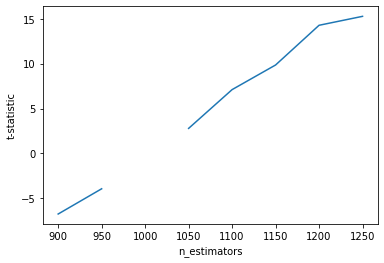

In [13]:
%pylab inline

t_stats = []
n_trees = []


from catboost import CatBoostRegressor


for j in range(900, 1300, 50):
    current_score = np.array([])
    for i in range(1):
        
        model = CatBoostRegressor(task_type="GPU", 
                         loss_function= 'MAE',
                         n_estimators=j,
                         devices='0:1')
        
        fold = KFold(n_splits=5, shuffle=True, random_state=i)
        scores_on_this_split = cross_val_score(model,
                                               x_train,
                                               y_train,
                                               cv=fold, scoring='neg_mean_absolute_error')
        
        current_score = np.append(current_score,scores_on_this_split)
        
    t_stat, p_value = ttest_rel(current_score, scores_n1_trees) # comparison between zero-thesis & . 
    # If 0, means the same accuracy
    t_stats.append(t_stat)
    n_trees.append(j)
    
plt.plot(n_trees, t_stats)
plt.xlabel('n_estimators')
plt.ylabel('t-statistic')

# 3.Check outliers (remove from corss-validation)

Outliers fraction in train =  0.30381974817760105

In [62]:
from sklearn.model_selection import cross_val_predict



from catboost import CatBoostRegressor
base_estimator = CatBoostRegressor(task_type="GPU", 
                         loss_function= 'MAE',
                         devices='0:1')


pred_train = cross_val_predict(base_estimator, x_train, y_train, cv=5)
abs_train_error = np.absolute(y_train - pred_train)
outlier_mask = (abs_train_error > 3)
print('Outliers fraction in train = ', float(y_train[outlier_mask].shape[0]) / y_train.shape[0])

0:	learn: 4.9581846	total: 41.5ms	remaining: 41.4s
1:	learn: 4.8507956	total: 83.2ms	remaining: 41.5s
2:	learn: 4.7479374	total: 123ms	remaining: 40.8s
3:	learn: 4.6496732	total: 163ms	remaining: 40.6s
4:	learn: 4.5564074	total: 202ms	remaining: 40.2s
5:	learn: 4.4658271	total: 241ms	remaining: 39.9s
6:	learn: 4.3795419	total: 280ms	remaining: 39.8s
7:	learn: 4.2978214	total: 319ms	remaining: 39.6s
8:	learn: 4.2218957	total: 358ms	remaining: 39.4s
9:	learn: 4.1463159	total: 397ms	remaining: 39.3s
10:	learn: 4.0763150	total: 434ms	remaining: 39s
11:	learn: 4.0096889	total: 473ms	remaining: 38.9s
12:	learn: 3.9473505	total: 512ms	remaining: 38.8s
13:	learn: 3.8917379	total: 550ms	remaining: 38.8s
14:	learn: 3.8372879	total: 587ms	remaining: 38.6s
15:	learn: 3.7813283	total: 624ms	remaining: 38.4s
16:	learn: 3.7331714	total: 662ms	remaining: 38.3s
17:	learn: 3.6941261	total: 701ms	remaining: 38.3s
18:	learn: 3.6559464	total: 739ms	remaining: 38.2s
19:	learn: 3.6149694	total: 778ms	remaini

In [63]:
pred_train

array([5.67332065, 6.09326043, 8.64458858, ..., 4.50682668, 3.7184649 ,
       4.41715532])

# Remove outliers 

0:	learn: 4.9688047	total: 40ms	remaining: 36s
1:	learn: 4.8608122	total: 80.2ms	remaining: 36s
2:	learn: 4.7576537	total: 119ms	remaining: 35.6s
3:	learn: 4.6590470	total: 157ms	remaining: 35.2s
4:	learn: 4.5656598	total: 196ms	remaining: 35s
5:	learn: 4.4745195	total: 234ms	remaining: 34.9s
6:	learn: 4.3897001	total: 273ms	remaining: 34.9s
7:	learn: 4.3073695	total: 312ms	remaining: 34.8s
8:	learn: 4.2310363	total: 351ms	remaining: 34.7s
9:	learn: 4.1550191	total: 390ms	remaining: 34.7s
10:	learn: 4.0824329	total: 429ms	remaining: 34.7s
11:	learn: 4.0170311	total: 469ms	remaining: 34.7s
12:	learn: 3.9581441	total: 508ms	remaining: 34.6s
13:	learn: 3.9030873	total: 547ms	remaining: 34.6s
14:	learn: 3.8431759	total: 585ms	remaining: 34.5s
15:	learn: 3.7909584	total: 622ms	remaining: 34.4s
16:	learn: 3.7376835	total: 660ms	remaining: 34.3s
17:	learn: 3.6985239	total: 699ms	remaining: 34.3s
18:	learn: 3.6607961	total: 738ms	remaining: 34.2s
19:	learn: 3.6205264	total: 777ms	remaining: 34

ValueError: x and y must have same first dimension, but have shapes (200,) and (4,)

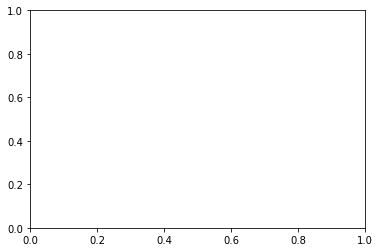

In [65]:
# import cross_val_custom from
# https://github.com/Danila89/cross_validation_custom
from cross_val_custom import cross_validation_score_statement
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from scipy.stats import ttest_rel

base_scores_train_v2 = np.array([])

for i in range(1):
    scores_on_this_split = cross_validation_score_statement(model_remove,
                                                            x_train,
                                                            y_train,
                                                            scoring=mean_absolute_error,
                                                            random_state=i, 
                                                            statement=~outlier_mask)
    
    base_scores_train_v2 = np.append(base_scores_train_v2,
                                     scores_on_this_split)
t_stats_train_v2 = []

for j in range(1000, 1500, 500):
    
    scores_train_v2 = np.array([])
    for i in range(1):
        
        from catboost import CatBoostRegressor
        model_remove = CatBoostRegressor(task_type="GPU",
                                         loss_function= 'MAE',
                                         n_estimators=j,
                                         devices='0:1')
        fold = KFold(n_splits=5, shuffle=True, random_state=i)
        scores_on_this_split = cross_validation_score_statement(model_remove,
                                                                newX,
                                                                y_train,
                                                                scoring=mean_absolute_error,
                                                                random_state=i, 
                                                                statement=~outlier_mask)
        scores_train_v2 = np.append(scores_train_v2,
                                    scores_on_this_split)
    t_stat,p_value = ttest_rel(scores_train_v2, base_scores_train_v2)
    t_stats_train_v2.append(t_stat)
#plt.plot(range(900,1100), t_stats_train_v2)
#plt.xlabel('n_estimators')
#plt.ylabel('t-statistic')

In [66]:
t_stats_train_v2

[nan, -2.4576265324036926, -2.809821700219243, -3.4658140435723]

# 4. Another models

### Stochastic Gradient Descent (SGD)

In [55]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import SGDRegressor

# x_train = data_prepare_x_train()
# y_train = data_prepare_y_train()

# scaler = StandardScaler()
# scaler.fit(newX)  # Don't cheat - fit only on training data
# X_train = scaler.transform(x_train)
# #x_test = scaler.transform(x_test)  # apply same transformation to test data

# # Or better yet: use a pipeline!
# from sklearn.pipeline import make_pipeline
# est = make_pipeline(StandardScaler(), SGDRegressor(max_iter=2000))
# est.fit(X_train, y_train)
# #est.predict(X_test)

In [43]:
newX[:2]

R         C  time_step      u_in     u_out         5
0 -1.729391 -0.359072   1.394522 -1.706609 -1.222761 -1.278552
1 -1.729391 -0.359072   1.394522 -1.662676  0.000000 -1.278552

In [56]:
#est.score(newX, y_train)

In [57]:
#show_scores(est, newX)

### Linear Regression

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(newX, y_train, test_size=0.2)

regr = LinearRegression()
regr.fit(x_train_2, y_train_2)

print('Training data r-squared:', regr.score(x_train_2, y_train_2))
print('Test data r-squared:', regr.score(x_test_2, y_test_2))
pd.DataFrame(data=regr.coef_, index=x_train_2.columns, columns=['coef'])

C:\Users\misha\Desktop\sample_project_1\env\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Training data r-squared: 0.38376409644490983
Test data r-squared: 0.3845016496494382


C:\Users\misha\Desktop\sample_project_1\env\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\misha\Desktop\sample_project_1\env\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


coef
R         -4.367279
C          4.351432
time_step  0.147569
u_in      -0.355398
u_out     -0.231189
5          0.600187
6         -4.538765

### Linear Regression with intervals

### NN

In [81]:
from sklearn.model_selection import train_test_split

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(newX, y_train, test_size=0.2)

In [82]:
# Load Tensorboard notebook extension
%load_ext tensorboard

In [83]:
import datetime
import os
import tensorflow as tf
# Function for TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing logs
    logdir = os.path.join("logs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)

In [84]:
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

In [85]:
from keras.models import Sequential
from keras.layers import Dense

np.random.seed(42)
tensorboard = create_tensorboard_callback()

model_NN = Sequential()
model_NN.add(Dense(128, activation='relu', input_shape=(x_train_2.shape[1],)))
#model_NN.add(Dense(128, activation='relu'))
model_NN.add(Dense(1))

model_NN.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [86]:
model_NN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               896       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________


In [88]:
# model_NN.fit(x_train_2,
#              y_train_2,
#              epochs=1,
#              validation_data=(x_test_2, y_test_2),
#              callbacks=[tensorboard, early_stopping], 
#              batch_size=1,
#              verbose=True)

In [89]:
%tensorboard --logdir logs/

# Catboost final

In [75]:
# from catboost import CatBoostRegressor
# from sklearn.model_selection import KFold, cross_val_score


# model_catboost = CatBoostRegressor( 
#                          task_type="GPU",,
#                          n_estimators=850,
#                          loss_function= 'MAE',                         
#                          devices='0:1')



# for i in range(1):
    
#     fold = KFold(n_splits=5, shuffle=True, random_state=i)
#     final_cross_validation_model = cross_val_score(model_catboost, x_train, y_train,cv=fold, scoring='neg_mean_absolute_error')


In [31]:
final_cross_validation_model.pr

array([-2.11263598, -2.0972211 , -2.11246998, -2.10479237, -2.11238769])

In [275]:
from catboost import CatBoostRegressor
model_catboost = CatBoostRegressor( 
                         task_type="GPU",
                         random_seed=42,
                         n_estimators=3000,
                         loss_function= 'MAE',
                         od_type='Iter',
                         od_wait=20,                          
                         devices='0:1')
model_catboost.fit(newX,
          y_train,
          plot=True,
          verbose=False,)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [278]:
show_scores(model_catboost, newX)

{'Training MAE': 2.2329106231692317}

# 5.Output

In [279]:
df_sample = pd.read_csv("data/ventilator-pressure-prediction/sample_submission.csv")

In [280]:
df_sample.columns

Index(['id', 'pressure'], dtype='object')

In [281]:
df_sample.shape

(4024000, 2)

In [282]:
x_test[:2]

id  breath_id  R   C  time_step      u_in  u_out
0   1          0  5  20   0.000000  0.000000      0
1   2          0  5  20   0.031904  7.515046      0

In [283]:
x_test = data_prepare_x_test()
x_test[:2]

id  breath_id  R   C  time_step      u_in  u_out
0   1          0  5  20   0.000000  0.000000      0
1   2          0  5  20   0.031904  7.515046      0

In [284]:
x_test = x_test.drop("id", axis=1)
x_test = x_test.drop("breath_id", axis=1)
# df_train = df_train.drop("R", axis=1)
# df_train = df_train.drop("C", axis=1)
#x_test = x_test.drop("u_out", axis=1)
x_test[:2]

R   C  time_step      u_in  u_out
0  5  20   0.000000  0.000000      0
1  5  20   0.031904  7.515046      0

In [285]:
x_train[:2]

R   C  time_step      u_in  u_out
0  20  50   0.000000  0.083334      0
1  20  50   0.033652  3.156334      0

In [286]:
y_preds = model_catboost.predict(x_test)

In [287]:
y_preds

array([10.18065549, 12.25951059, 12.05679369, ...,  8.51560311,
        8.51560311,  8.51560311])

In [288]:
y_preds.shape

(4024000,)

In [289]:
df_sample["pressure"] = y_preds

In [291]:
df_sample[:2]

id   pressure
0   1  10.180655
1   2  12.259511

In [292]:
df_sample.to_csv("E:\downloads\sample_submission.csv", index=False)